In [ ]:
!pip install pmdarima

In [ ]:
# All import statements go here

import statsmodels
import random
from numpy import random as rnd1
from tabulate import tabulate
import numpy as np
import pandas as pd
import scipy
from itertools import repeat
from sklearn.linear_model import LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
import pandas.util.testing as tm
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt


##supress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#All function definitions go here

def init_elast_dist(num_rows, num_cols):
  res0 = [[1 for i in range(num_cols)] for j in range(num_rows) ]
  for l in range(0, num_rows):
    for k in range(0,num_cols):
      res0[l][k] = round( random.uniform(-3, -1), 2 )
  
  return np.array(res0)

def init_epsilon_vector(num_cols, epsilon_mean, epsilon_std):
  res1 = [1 for i in range(num_cols)]
  for l in range(0, num_cols):
    res1[l] = round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 2 )
  
  return np.array(res1)

def init_price_vector(num_rows, num_cols, p_array):
  res2 = [ [1]*num_cols for i in range(num_rows) ]
  for nc in range(0,num_cols):
    if nc == 0:
      for nr in range(0,num_rows):
        res2[nr][nc] = p_array[nr]
    else:
      for nr in range(0,num_rows):
        res2[nr][nc] = res2[nr][0] + random.randint(1,5)

  return np.array(res2)

def init_demand_vector(num_rows, num_cols, d_array):
  res2 = [ [0]*num_cols for i in range(num_rows) ]
  for nc in range(0,num_cols):
    if nc == 0:
      for nr in range(0,num_rows):
        res2[nr][nc] = d_array[nr]
    else:
      for nr in range(0,num_rows):
        res2[nr][nc] = res2[nr][0] + random.randint(1,10)

  return np.array(res2)

def init_forecast_vector(num_rows, num_cols):
  res2 = [ [0]*num_cols for i in range(num_rows) ]
  for l in range(0, num_rows):
    for k in range(0,num_cols):
      res2[l][k] = 0.0
  
  return np.array(res2)


def generate_init_data(price_vector, forecast_vector, demand_vector, elasticity_distrib, epsilon_vector, number_items_basket, Time_period, c_zero, Beta, p_array, d_array):
  elasticity_distrib = init_elast_dist(number_items_basket, Time_period)

  #creating a guassian epsilon vector
  epsilon_mean = 0
  epsilon_std = 1
  epsilon_vector = init_epsilon_vector(Time_period, epsilon_mean, epsilon_std)

  #initializing price(i,0) of all items in the basket as 12
  price_vector = init_price_vector(number_items_basket, Time_period, p_array)
  #initializing demand vector
  demand_vector = init_demand_vector(number_items_basket, Time_period, d_array)
  #initializing forecast vector
  forecast_vector = init_forecast_vector(number_items_basket, Time_period)
  

  for nrow in range(0, number_items_basket):
    for ncol in range(0, Time_period):
      dem_sum_0 = 0
      if ncol > 0:
        for ncol1 in range(0, ncol):
          dem_sum_0 = dem_sum_0 + ((Beta**(ncol-ncol1))*(demand_vector[nrow][ncol1]))
        forecast_vector[nrow][ncol] = round((c_zero + dem_sum_0 + epsilon_vector[ncol-1]), 2)
        demand_vector[nrow][ncol] = round( ((forecast_vector[nrow][ncol])*((price_vector[nrow][ncol]/price_vector[nrow][ncol-1])**(elasticity_distrib[nrow][ncol]))) + (epsilon_vector[ncol-1]) )
      else:
        forecast_vector[nrow][ncol] = demand_vector[nrow][ncol]

  ret_arr_init = [None]*5
  ret_arr_init[0] = price_vector
  ret_arr_init[1] = forecast_vector
  ret_arr_init[2] = demand_vector
  ret_arr_init[3] = elasticity_distrib
  ret_arr_init[4] = epsilon_vector

  return ret_arr_init


def Demand_Modeller(price_item, forecast_item, demand_item, elasticity_distrib, epsilon_vector, num_rows, num_cols, c_zero, Beta):
  #holds forecast at time t
  
  vect_f = []
  vect_e = []
  vect_p = []
  vect_d = []
  vect_r = []
  prev_price1 = price_item[: , num_cols-1]

  for i in range(0,num_rows):
    dem_sum = 0
    for j in range(0, (num_cols)):
      dem_sum = dem_sum + ((Beta**(num_cols-j))*(demand_item[i][j]))
    pred_val1 = round((c_zero + dem_sum + epsilon_vector[num_cols-1]), 2)
    vect_f.append(pred_val1)

    model_e = auto_arima(elasticity_distrib[i], start_p=0, start_q=0)
    pred_val2 = model_e.predict(n_periods = 1)
    vect_e.append(round(pred_val2[0], 2))

    model_p = auto_arima(price_item[i], start_p=0, start_q=0)
    pred_val3 = model_p.predict(n_periods = 1)
    vect_p.append(round(pred_val3[0], 2))

    terma = pred_val1
    termb = round(pred_val3[0], 2)
    termc = round(pred_val2[0], 2)
    pred_val4 = (terma)*( (termb/prev_price1[i])**(termc) )
    pred_val4 = pred_val4 + (epsilon_vector[num_cols-1])
    pred_val5 = round( max(pred_val4,0) )
    vect_d.append(pred_val5)

  vect_r.append(vect_f)
  vect_r.append(vect_e)
  vect_r.append(vect_p)
  vect_r.append(vect_d)
  return vect_r



def Demand_Modeller_Guassian(price_item, forecast_item, demand_item, elasticity_distrib, epsilon_vector, num_rows, num_cols, elasticity_new_a, c_zero, Beta):
  #holds forecast at time t
  
  vect_f = []
  vect_p = []
  vect_d = []
  vect_r = []
  prev_price1 = price_item[: , num_cols-1]


  for i in range(0,num_rows):
    dem_sum = 0
    for j in range(0, (num_cols)):
      dem_sum = dem_sum + ((Beta**(num_cols-j))*(demand_item[i][j]))
    pred_val1 = round((c_zero + dem_sum + epsilon_vector[num_cols-1]), 2)
    vect_f.append(pred_val1)

    pred_val2 = elasticity_new_a[i]

    model_p = auto_arima(price_item[i], start_p=0, start_q=0)
    pred_val3 = model_p.predict(n_periods = 1)
    vect_p.append(round(pred_val3[0], 2))

    terma = pred_val1
    termb = round(pred_val3[0], 2)
    termc = round(pred_val2, 2)
    pred_val4 = (terma)*( (termb/prev_price1[i])**(termc) )
    pred_val4 = pred_val4 + (epsilon_vector[num_cols-1])
    pred_val5 = round( max(pred_val4,0) )
    vect_d.append(pred_val5)

  vect_r.append(vect_f)
  vect_r.append(vect_p)
  vect_r.append(vect_d)
  return vect_r

##Revenue Calculation code
def Decrement_price(price_arr, index, dec_price):
  price_arr1 = np.array(price_arr).copy()
  if price_arr1[index] >= 6.0:
    price_arr1[index] = price_arr1[index] - dec_price
  
  return price_arr1.copy()

def Increment_price(price_arr, index, inc_price):
  price_arr1 = np.array(price_arr).copy()
  price_arr1[index] = price_arr1[index] + inc_price
  
  return price_arr1.copy()


def Calculate_Revenue(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket):
  Revenue_passive1 = 0
  for iter1 in range(0, number_items_basket):
    Revenue_passive1 = Revenue_passive1 + (price_passive[iter1]*price_passive[iter1]*Baseline_demand_passive[iter1]*elast_distrib_passive[iter1]/price_passive_minus_one[iter1]) - (price_passive[iter1]*Baseline_demand_passive[iter1]*elast_distrib_passive[iter1]) + (price_passive[iter1]*Baseline_demand_passive[iter1])
  
  return Revenue_passive1

def Find_Optimal_Price_Basket(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket, flag):
  rev_pass2 = 0
  rev_pass3 = 0
  price_passive_r = price_passive.copy()
  #print("price array init: ", price_passive_r)
  for iter1 in range(0, number_items_basket):
    for iter2 in range(0,60):
      rev_pass3 = Calculate_Revenue(price_passive, price_passive_minus_one, Baseline_demand_passive, elast_distrib_passive, number_items_basket)
      if rev_pass2 <= rev_pass3:
        rev_pass2 = rev_pass3
        price_passive_r = price_passive.copy()
      if flag == 0:
        price_passive = Increment_price(price_passive, iter1, 0.1)
      else:
        price_passive = Decrement_price(price_passive, iter1, 0.1)
        
  
  #print("price array final: ", price_passive_r)
  ret_array_p = [None]*2
  ret_array_p[0] = np.array(price_passive_r)
  ret_array_p[1] = round(rev_pass2,2)

  return ret_array_p


##Additional Guassian Functions - new code
def compute_theta_vector(price_vector, price_vector_prev, forecast_vector, number_items_basket):
  r_array = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array[j1] = round( ( ((price_vector[j1]*price_vector[j1]*forecast_vector[j1])/(price_vector_prev[j1])) - (price_vector[j1]*forecast_vector[j1]) ), 2)
  
  return r_array

def compute_revenue_bar_vector(price_vector, forecast_vector, number_items_basket):
  r_array1 = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array1[j1] = round( (price_vector[j1]*forecast_vector[j1]), 2)
  
  return r_array1

def compute_revenue_vector(price_vector, demand_vector, number_items_basket):
  r_array1 = np.zeros(number_items_basket)
  for j1 in range(0,number_items_basket):
    r_array1[j1] = round( (price_vector[j1]*demand_vector[j1]), 2)
  
  return r_array1

def compute_array_sum(vector, number_items_basket):
  arr_sum1 = 0
  for j1 in range(0,number_items_basket):
    arr_sum1 = arr_sum1 + vector[j1]
  
  return round(arr_sum1 , 2)

def round_vec_op(array_1d):
  array_id_r = []
  for iter1 in range(0, len(array_1d)):
    v_app_t = array_1d[iter1]
    v_app_tr = round(v_app_t, 2)
    array_id_r.append(v_app_tr)
  
  return np.array(array_id_r)



def random_guass_sample(guassian_x, num_rows, number_items_basket):
  rand_sample_x = []
  rand_count = 0
  guassian_f = guassian_x.flatten()
  while rand_count < number_items_basket:
    r_value = np.random.choice(guassian_f)
    if r_value <= -1.0:
      rand_sample_x.append(r_value)
      rand_count = rand_count + 1
  
  return np.array(rand_sample_x)

def Generate_New_Elasticity_Guassian(price_vector, price_vector_prev, forecast_vector, demand_vector, number_items_basket, elasticity_mean, cov_matrix, std_dev_dist, lambda_const):
  ##Code for -- guassian prior on elasticity vector and the associated modification of mean and covariance vectors
  theta_vector = compute_theta_vector(price_vector, price_vector_prev, forecast_vector, number_items_basket)
  revenue_bar_vector = compute_revenue_bar_vector(price_vector, forecast_vector, number_items_basket)
  revenue_vector = compute_revenue_vector(price_vector, demand_vector, number_items_basket)

  #Performing the necessary matrix operations
  theta_2d = np.asmatrix(theta_vector.reshape(-1,1))
  theta_2d_t = np.asmatrix(theta_vector.reshape(1,-1))
  theta_2d_mult1 = np.dot(theta_2d, theta_2d_t)
  theta_2d_mult2 = theta_2d_mult1*(1/(std_dev_dist*std_dev_dist))
  temp_id_arr1 = np.asmatrix(np.identity(number_items_basket, dtype = float))
  temp_id_arr2 = temp_id_arr1*lambda_const
  M_t_inv = np.add(theta_2d_mult2, temp_id_arr2)

  cov_inv = np.linalg.inv(np.asmatrix(cov_matrix))
  temp_inv_1 = np.add(M_t_inv, cov_inv)
  cov_mod = np.linalg.inv(temp_inv_1) ##modified covariance

  elasticity_mean_2d = np.asmatrix(elasticity_mean.reshape(-1,1))

  temp_part1 = np.dot(cov_inv, elasticity_mean_2d)

  rev_bar_sum = compute_array_sum(revenue_bar_vector, number_items_basket)
  rev_bar = compute_array_sum(revenue_vector, number_items_basket)
  temp_part2_mult = ((rev_bar - rev_bar_sum)/(std_dev_dist*std_dev_dist))
  temp_part2 = theta_2d*temp_part2_mult

  temp_part3 = np.add(temp_part1, temp_part2)
  elasticity_mean_mod = np.dot(cov_mod, temp_part3)  #modified elasticity mean vector

  cov_mod_arr = np.array(cov_mod)
  elasticity_mean_mod_arr = np.array(elasticity_mean_mod)
  guassian_x = np.random.multivariate_normal(mean=elasticity_mean_mod_arr.flatten(), cov=cov_mod_arr, size=100)
  elasticity_new_x = random_guass_sample(guassian_x, 100, number_items_basket) #randomly sampling for the new elasticity vector

  ret_arr_x = [None]*3
  ret_arr_x[0] = cov_mod_arr
  ret_arr_x[1] = elasticity_mean_mod_arr.flatten()
  ret_arr_x[2] = elasticity_new_x

  
  return ret_arr_x



In [ ]:
data_csv = pd.read_csv("/content/Order Details.csv")
top_10_r = data_csv.head(10)
print(top_10_r) ##Observe that Order Id represents the shopping basket

  Order ID  Amount  Profit  Quantity     Category      Sub-Category
0  B-25601  1275.0 -1148.0         7    Furniture         Bookcases
1  B-25601    66.0   -12.0         5     Clothing             Stole
2  B-25601     8.0    -2.0         3     Clothing       Hankerchief
3  B-25601    80.0   -56.0         4  Electronics  Electronic Games
4  B-25602   168.0  -111.0         2  Electronics            Phones
5  B-25602   424.0  -272.0         5  Electronics            Phones
6  B-25602  2617.0  1151.0         4  Electronics            Phones
7  B-25602   561.0   212.0         3     Clothing             Saree
8  B-25602   119.0    -5.0         8     Clothing             Saree
9  B-25603  1355.0   -60.0         5     Clothing          Trousers


In [ ]:
data_csv_req = data_csv[["Order ID","Amount", "Quantity", "Category", "Sub-Category"]]
print(data_csv_req.head(10))

  Order ID  Amount  Quantity     Category      Sub-Category
0  B-25601  1275.0         7    Furniture         Bookcases
1  B-25601    66.0         5     Clothing             Stole
2  B-25601     8.0         3     Clothing       Hankerchief
3  B-25601    80.0         4  Electronics  Electronic Games
4  B-25602   168.0         2  Electronics            Phones
5  B-25602   424.0         5  Electronics            Phones
6  B-25602  2617.0         4  Electronics            Phones
7  B-25602   561.0         3     Clothing             Saree
8  B-25602   119.0         8     Clothing             Saree
9  B-25603  1355.0         5     Clothing          Trousers


In [ ]:
#Extracting data for the order id (basket) which has 10 items in it
data_csv_req_bask = data_csv_req[(data_csv_req['Order ID'] == 'B-25651')]
print(data_csv_req_bask.head(10))




    Order ID  Amount  Quantity   Category Sub-Category
121  B-25651   200.0         4  Furniture    Bookcases
122  B-25651    44.0         3   Clothing        Stole
123  B-25651     7.0         1   Clothing     Leggings
124  B-25651    11.0         2   Clothing        Skirt
125  B-25651    16.0         2   Clothing      T-shirt
126  B-25651   172.0         3  Furniture       Chairs
127  B-25651    49.0         1   Clothing        Shirt
128  B-25651   823.0         7  Furniture       Chairs
129  B-25651    23.0         1   Clothing        Saree
130  B-25651   457.0         4   Clothing        Saree


In [ ]:
p_array_sb = np.array(data_csv_req_bask['Amount'])
d_array_sb = np.array(data_csv_req_bask['Quantity'])

In [ ]:
#All code goes in the below section
#initialize all vectors
price_vector = np.array([])
forecast_vector = np.array([])
demand_vector = np.array([])
elasticity_distrib = np.array([])
epsilon_vector = np.array([])
init_out = np.array([])

number_items_basket = len(p_array_sb)      ##This is the number of items in a basket
#Step 1 -- generate base dataset for a fixed time period (30 days of data)
Time_period = 10

c_zero = 0.15  ##taking c0 as a small positive constant as suggested in the paper
Beta = 0.5
std_dev_dist = 1
lambda_const = 0.18  ##taking lambda as a small positive constant as suggested in the paper

epsilon_mean = 0
epsilon_std = 1

init_out = generate_init_data(price_vector, forecast_vector, demand_vector, elasticity_distrib, epsilon_vector, number_items_basket, Time_period, c_zero, Beta, p_array_sb, d_array_sb)
price_vector = init_out[0]
forecast_vector = init_out[1]
demand_vector = init_out[2]
elasticity_distrib = init_out[3]
epsilon_vector = init_out[4]

##added code starts here
elasticity_mean = np.array( np.mean(elasticity_distrib, axis = 1) )
elasticity_mean = round_vec_op(elasticity_mean)
cov_matrix1 = np.identity(number_items_basket, dtype = float)
cov_matrix2 = cov_matrix1*c_zero
guassian_0 = np.random.multivariate_normal(mean=elasticity_mean, cov=cov_matrix2, size=100)
elasticity_new1 = random_guass_sample(guassian_0, 100, number_items_basket) #randomly sampling for the new elasticity vector
##added code ends here

print("price vector")
print(tabulate(price_vector, tablefmt="fancy_grid"))
print()

print("forecast vector")
print(tabulate(forecast_vector, tablefmt="fancy_grid"))
print()

print("demand vector")
print(tabulate(demand_vector, tablefmt="fancy_grid"))
print()

print("elasticity vector")
print(tabulate(elasticity_distrib, tablefmt="fancy_grid"))
print()

# print("epsilon vector")
# print(tabulate(epsilon_vector.reshape(1,-1), tablefmt="fancy_grid"))
# print()

##added code starts here
print("initial elasticity mean vector")
print(tabulate(elasticity_mean.reshape(-1,1), tablefmt="fancy_grid"))
print()

print("initial covariance matrix")
print(tabulate(cov_matrix2, tablefmt="fancy_grid"))
print()

print("elasticity_new1")
print(tabulate(elasticity_new1.reshape(-1,1), tablefmt="fancy_grid"))
print()


price vector
╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╕
│ 200 │ 201 │ 202 │ 204 │ 202 │ 203 │ 201 │ 202 │ 202 │ 205 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  44 │  45 │  49 │  48 │  45 │  47 │  46 │  46 │  49 │  45 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│   7 │   8 │  11 │  12 │   9 │  11 │  10 │   9 │   9 │   8 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  11 │  12 │  16 │  16 │  16 │  13 │  14 │  15 │  14 │  12 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  16 │  20 │  21 │  17 │  18 │  19 │  17 │  18 │  20 │  21 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ 172 │ 174 │ 176 │ 177 │ 173 │ 177 │ 173 │ 176 │ 175 │ 177 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│  49 │  50 │  51 │  51 │  52 │  52 │  51 │  51 │  52 │  54 │
├─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┼─────┤
│ 823 │ 824 │ 824 │ 825 │ 828 │ 824 │ 826 │ 827 │ 827 │ 8

In [ ]:
#Projecting for titer periods - To see the comparative performace of Passive vs Active models

titer = 60  ##number of periods for which prices have to be forecasted upto
num_trails_con = 15  ##number of trails conducted, over which the revenue is averaged
x1 = np.zeros(titer)
rev_arr10 = np.zeros(titer)
rev_arr11 = np.zeros(titer)

price_vector_final_p = np.array([])
forecast_vector_final_p = np.array([])
demand_vector_final_p = np.array([])
elasticity_distrib_final_p = np.array([])

price_vector_final_a = np.array([])
forecast_vector_final_a = np.array([])
demand_vector_final_a = np.array([])
elasticity_distrib_final_a = np.array([])


for temp_c in range(0,titer):
  x1[temp_c] = temp_c + 1


for jiter in range(0, num_trails_con):
  Time_period1 = Time_period
  Time_period2 = Time_period
  price_vector1 = price_vector.copy()
  price_vector2 = price_vector.copy()
  forecast_vector1 = forecast_vector.copy()
  forecast_vector2 = forecast_vector.copy()
  demand_vector1 = demand_vector.copy()
  demand_vector2 = demand_vector.copy()
  elasticity_distrib1 = elasticity_distrib.copy()
  elasticity_distrib2 = elasticity_distrib.copy()
  epsilon_vector1 = epsilon_vector.copy()
  epsilon_vector2 = epsilon_vector.copy()

  elasticity_new_a = elasticity_new1.copy()
  #print("round %i: " %(jiter+1))
  #print()

  for iter3 in range(0,titer):
    dm_x1 = Demand_Modeller(price_vector1, forecast_vector1, demand_vector1, elasticity_distrib1, epsilon_vector1, number_items_basket, Time_period1, c_zero, Beta)
    Baseline_demand_f_x1 = np.array(dm_x1[0])
    elast_f_x1 = np.array(dm_x1[1])
    price_f_x1 = np.array(dm_x1[2])
    demand_f_x1 = np.array(dm_x1[3])

    #append newly generated columns for Passive Algorithm
    forecast_vector1 = np.append(forecast_vector1, Baseline_demand_f_x1.reshape(-1,1), axis=1)
    elasticity_distrib1 = np.append(elasticity_distrib1, elast_f_x1.reshape(-1,1), axis=1)
    price_vector1 = np.append(price_vector1, price_f_x1.reshape(-1,1), axis=1)
    demand_vector1 = np.append(demand_vector1, demand_f_x1.reshape(-1,1), axis=1)
    epsilon_vector1 = np.append(epsilon_vector1, round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 2 ) )
    Time_period1 = Time_period1 + 1

    dm_x2 = Demand_Modeller_Guassian(price_vector2, forecast_vector2, demand_vector2, elasticity_distrib2, epsilon_vector2, number_items_basket, Time_period2, elasticity_new_a, c_zero, Beta)
    Baseline_demand_f_x2 = np.array(dm_x2[0])
    price_f_x2 = np.array(dm_x2[1])
    demand_f_x2 = np.array(dm_x2[2])
    elast_f_x2 = Generate_New_Elasticity_Guassian(price_f_x2, price_vector2[:, (Time_period2 - 1)], Baseline_demand_f_x2, demand_f_x2, number_items_basket, elasticity_mean, cov_matrix2, std_dev_dist, lambda_const)
    new_cov1 = elast_f_x2[0]
    new_mean_el1 = elast_f_x2[1]
    elast_new_vect = elast_f_x2[2]

    elast_f_x2_new = elast_new_vect.copy()
    elasticity_new_a = elast_new_vect.copy()

    #Debug code start
    # print("elasticity_new_a: ", elasticity_new_a)
    # print()
    #Debug code end

    elasticity_mean = new_mean_el1.copy()
    cov_matrix2 = new_cov1.copy()

    #append newly generated columns for Active Algorithm
    forecast_vector2 = np.append(forecast_vector2, Baseline_demand_f_x2.reshape(-1,1), axis=1)
    elasticity_distrib2 = np.append(elasticity_distrib2, elast_f_x2_new.reshape(-1,1), axis=1)
    price_vector2 = np.append(price_vector2, price_f_x2.reshape(-1,1), axis=1)
    demand_vector2 = np.append(demand_vector2, demand_f_x2.reshape(-1,1), axis=1)
    epsilon_vector2 = np.append(epsilon_vector2, round( scipy.stats.norm(epsilon_mean, epsilon_std).pdf(1.5) , 2 ) )
    Time_period2 = Time_period2 + 1

    ## updation
    price_vector_final_p = price_vector1.copy()
    forecast_vector_final_p = forecast_vector1.copy()
    demand_vector_final_p = demand_vector1.copy()
    elasticity_distrib_final_p = elasticity_distrib1.copy()

    price_vector_final_a = price_vector2.copy()
    forecast_vector_final_a = forecast_vector2.copy()
    demand_vector_final_a = demand_vector2.copy()
    elasticity_distrib_final_a = elasticity_distrib2.copy()


    price_vec_minus_one1 = price_vector1[:, (Time_period1-2)]
    price_vec_minus_one2 = price_vector2[:, (Time_period2-2)]


    opt_pb1 = Find_Optimal_Price_Basket(price_f_x1, price_vec_minus_one1, Baseline_demand_f_x1, elast_f_x1, number_items_basket, 0)
    opt_pb2 = Find_Optimal_Price_Basket(price_f_x2, price_vec_minus_one2, Baseline_demand_f_x2, elast_f_x2_new, number_items_basket, 1)

    price_opt1 = opt_pb1[0]
    revenue_opt1 = opt_pb1[1]
    print("Revenue projected by the passive algoritm for period %i - Iteration %i: " % (Time_period1, (jiter+1)), revenue_opt1)
    print()

    price_opt2 = opt_pb2[0]
    revenue_opt2 = opt_pb2[1]
    print("Revenue projected by the active algoritm for period %i - - Iteration %i: " % (Time_period2, (jiter+1)), revenue_opt2)
    print()
    
    rev_arr10[iter3] = rev_arr10[iter3] + revenue_opt1
    rev_arr11[iter3] = rev_arr11[iter3] + revenue_opt2

#calculating average revenue across trails
avg_rev10 = np.divide(rev_arr10, num_trails_con)
avg_rev11 = np.divide(rev_arr11, num_trails_con)



Revenue projected by the passive algoritm for period 11 - Iteration 1:  6026.79

Revenue projected by the active algoritm for period 11 - - Iteration 1:  7145.23

Revenue projected by the passive algoritm for period 12 - Iteration 1:  6060.22

Revenue projected by the active algoritm for period 12 - - Iteration 1:  10883.98

Revenue projected by the passive algoritm for period 13 - Iteration 1:  6074.17

Revenue projected by the active algoritm for period 13 - - Iteration 1:  8596.91

Revenue projected by the passive algoritm for period 14 - Iteration 1:  6090.15

Revenue projected by the active algoritm for period 14 - - Iteration 1:  7406.83

Revenue projected by the passive algoritm for period 15 - Iteration 1:  6089.59

Revenue projected by the active algoritm for period 15 - - Iteration 1:  8094.29

Revenue projected by the passive algoritm for period 16 - Iteration 1:  6092.52

Revenue projected by the active algoritm for period 16 - - Iteration 1:  10100.21

Revenue projected by

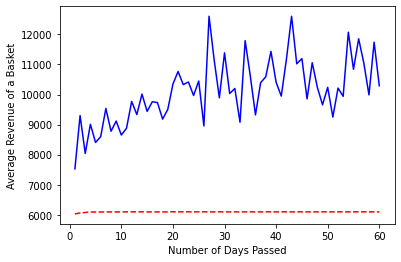

In [ ]:
# print("Average revenue Generated across the basket (Passive) : ")
# print(tabulate(avg_rev10.reshape(-1,1), tablefmt="fancy_grid"))
# print()

# print("Average revenue Generated across the basket (Active) : ")
# print(tabulate(avg_rev11.reshape(-1,1), tablefmt="fancy_grid"))
# print()

plt.plot(x1, avg_rev11, 'b')
plt.plot(x1, avg_rev10, 'r', linestyle = 'dashed')
plt.xlabel("Number of Days Passed")
plt.ylabel("Average Revenue of a Basket")
plt.show()

### Note: 'Blue line' represents active model, while the 'Red Line' represents passive model -- Active model greatly outperforms the passive model as suggested in the paper

In [ ]:
# print("Final Price vector passive: ")
# print(tabulate(price_vector_final_p, tablefmt="fancy_grid"))
# print()

# print("Final Price vector active: ")
# print(tabulate(price_vector_final_a, tablefmt="fancy_grid"))
# print()

# print("------------------------------------------------")
# print("------------------------------------------------")

# print("Final forecast vector passive: ")
# print(tabulate(forecast_vector_final_p, tablefmt="fancy_grid"))
# print()


# print("Final forecast vector active: ")
# print(tabulate(forecast_vector_final_a, tablefmt="fancy_grid"))
# print()

